In [11]:
import os
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset

In [2]:
path = os.getcwd()
save_path = os.path.join(path,"save")

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(1016) # Seed 고정

In [4]:
# 데이터 로딩 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): csv 파일의 경로.
            transform (callable, optional): 샘플에 적용될 Optional transform.
        """
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df['img_path'].iloc[idx]
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
size = 128
# 이미지 전처리 및 임베딩
transform = transforms.Compose([
    transforms.Resize((size,size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229]),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_data = CustomDataset(csv_file=os.path.join(path,"train.csv"), transform=transform)
train_loader = DataLoader(train_data, batch_size=16, shuffle=False)

In [6]:
# CNN 기반 Autoencoder 모델 정의
class AutoencoderCNN(nn.Module):
    def __init__(self):
        super(AutoencoderCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.3),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.3),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.3),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.3),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.3),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.3),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.3),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = torch.flatten(x, 1)
        return x

In [7]:
torch.cuda.manual_seed(10)
model = AutoencoderCNN().to(device)

# 손실 함수 및 최적화 기준 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 1000
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        images = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images.view(images.size(0), -1).to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader.dataset)}")

Epoch [1/1000], Loss: 0.5613105592313506
Epoch [2/1000], Loss: 0.37606411122939953
Epoch [3/1000], Loss: 0.31726178946629374
Epoch [4/1000], Loss: 0.28928767375543085
Epoch [5/1000], Loss: 0.2548403506967383
Epoch [6/1000], Loss: 0.22294897316767018
Epoch [7/1000], Loss: 0.19531967844201925
Epoch [8/1000], Loss: 0.1821577527993162
Epoch [9/1000], Loss: 0.17467340617112712
Epoch [10/1000], Loss: 0.16942302211069724
Epoch [11/1000], Loss: 0.1648832315430395
Epoch [12/1000], Loss: 0.16073023146586798
Epoch [13/1000], Loss: 0.15718638645091526
Epoch [14/1000], Loss: 0.15443300641198673
Epoch [15/1000], Loss: 0.15230014626408966
Epoch [16/1000], Loss: 0.15064720711517782
Epoch [17/1000], Loss: 0.1493231131577156
Epoch [18/1000], Loss: 0.14818532583019542
Epoch [19/1000], Loss: 0.14704059987840518
Epoch [20/1000], Loss: 0.14612793215843434
Epoch [21/1000], Loss: 0.14535941162579497
Epoch [22/1000], Loss: 0.14467226353609505
Epoch [23/1000], Loss: 0.14390703280207137
Epoch [24/1000], Loss: 0.

Epoch [192/1000], Loss: 0.1330861850103862
Epoch [193/1000], Loss: 0.13301821458787425
Epoch [194/1000], Loss: 0.13304537793560206
Epoch [195/1000], Loss: 0.1328547689976267
Epoch [196/1000], Loss: 0.13281298425275956
Epoch [197/1000], Loss: 0.132825600709154
Epoch [198/1000], Loss: 0.1328080821904778
Epoch [199/1000], Loss: 0.13281946898626049
Epoch [200/1000], Loss: 0.1327809515833295
Epoch [201/1000], Loss: 0.13279124422812125
Epoch [202/1000], Loss: 0.13286950694563243
Epoch [203/1000], Loss: 0.1328764753022664
Epoch [204/1000], Loss: 0.132735497025257
Epoch [205/1000], Loss: 0.13273995128315938
Epoch [206/1000], Loss: 0.1327158936732252
Epoch [207/1000], Loss: 0.13268971408197017
Epoch [208/1000], Loss: 0.13269589316677038
Epoch [209/1000], Loss: 0.13265726271089814
Epoch [210/1000], Loss: 0.1326628138481731
Epoch [211/1000], Loss: 0.13269809553041145
Epoch [212/1000], Loss: 0.13275524141363135
Epoch [213/1000], Loss: 0.13272225325096382
Epoch [214/1000], Loss: 0.1326644177867773


Epoch [380/1000], Loss: 0.13145997826482209
Epoch [381/1000], Loss: 0.13140114330349953
Epoch [382/1000], Loss: 0.13138513336998756
Epoch [383/1000], Loss: 0.1313696244093174
Epoch [384/1000], Loss: 0.13135878972604242
Epoch [385/1000], Loss: 0.13134286010489218
Epoch [386/1000], Loss: 0.1313593115465182
Epoch [387/1000], Loss: 0.13133688334008337
Epoch [388/1000], Loss: 0.1313435904716662
Epoch [389/1000], Loss: 0.13133208677522454
Epoch [390/1000], Loss: 0.13130925364897283
Epoch [391/1000], Loss: 0.13130289700949135
Epoch [392/1000], Loss: 0.13131964423566916
Epoch [393/1000], Loss: 0.1314078993360761
Epoch [394/1000], Loss: 0.13149185807492253
Epoch [395/1000], Loss: 0.13134936764486518
Epoch [396/1000], Loss: 0.131393454514199
Epoch [397/1000], Loss: 0.13134002314766807
Epoch [398/1000], Loss: 0.13132667499528805
Epoch [399/1000], Loss: 0.13129043600089113
Epoch [400/1000], Loss: 0.1313221835894204
Epoch [401/1000], Loss: 0.13127091694885576
Epoch [402/1000], Loss: 0.1312482143651

Epoch [568/1000], Loss: 0.13075088832020199
Epoch [569/1000], Loss: 0.13071194438027664
Epoch [570/1000], Loss: 0.1306715426450604
Epoch [571/1000], Loss: 0.1306618501742681
Epoch [572/1000], Loss: 0.1306847594153713
Epoch [573/1000], Loss: 0.13066292697555024
Epoch [574/1000], Loss: 0.13067254682941615
Epoch [575/1000], Loss: 0.13067295538707518
Epoch [576/1000], Loss: 0.1306768964293977
Epoch [577/1000], Loss: 0.13067739243518578
Epoch [578/1000], Loss: 0.13066855024004206
Epoch [579/1000], Loss: 0.1307485603810476
Epoch [580/1000], Loss: 0.13068698717394905
Epoch [581/1000], Loss: 0.1306867799568624
Epoch [582/1000], Loss: 0.1307541464276157
Epoch [583/1000], Loss: 0.1307549859296548
Epoch [584/1000], Loss: 0.13070932646312625
Epoch [585/1000], Loss: 0.1306629113048455
Epoch [586/1000], Loss: 0.13063826247560026
Epoch [587/1000], Loss: 0.13061856209112446
Epoch [588/1000], Loss: 0.1306091954870403
Epoch [589/1000], Loss: 0.13062452612348566
Epoch [590/1000], Loss: 0.1306225972975923

Epoch [756/1000], Loss: 0.1303057076645569
Epoch [757/1000], Loss: 0.1302853419747151
Epoch [758/1000], Loss: 0.13029305692849585
Epoch [759/1000], Loss: 0.1303027717160507
Epoch [760/1000], Loss: 0.13030855637480956
Epoch [761/1000], Loss: 0.1303085141198736
Epoch [762/1000], Loss: 0.13030070612128353
Epoch [763/1000], Loss: 0.1302798848616685
Epoch [764/1000], Loss: 0.13026515481897363
Epoch [765/1000], Loss: 0.13025789998226883
Epoch [766/1000], Loss: 0.13024420476575413
Epoch [767/1000], Loss: 0.13022838630866557
Epoch [768/1000], Loss: 0.13021925385569183
Epoch [769/1000], Loss: 0.13021992930504078
Epoch [770/1000], Loss: 0.1302107807616113
Epoch [771/1000], Loss: 0.1302066570576368
Epoch [772/1000], Loss: 0.13022148965949742
Epoch [773/1000], Loss: 0.13021855413074224
Epoch [774/1000], Loss: 0.13022128747942302
Epoch [775/1000], Loss: 0.13022240471672003
Epoch [776/1000], Loss: 0.1302315849513515
Epoch [777/1000], Loss: 0.13023542364438376
Epoch [778/1000], Loss: 0.13028377567378

Epoch [944/1000], Loss: 0.13002310630301356
Epoch [945/1000], Loss: 0.13008632878182638
Epoch [946/1000], Loss: 0.13009773019893628
Epoch [947/1000], Loss: 0.13001104524717644
Epoch [948/1000], Loss: 0.13000466398230182
Epoch [949/1000], Loss: 0.13000176721055742
Epoch [950/1000], Loss: 0.1299990926969779
Epoch [951/1000], Loss: 0.129988024072468
Epoch [952/1000], Loss: 0.1300167117460233
Epoch [953/1000], Loss: 0.13002232045914647
Epoch [954/1000], Loss: 0.1300459065487687
Epoch [955/1000], Loss: 0.13007175866426995
Epoch [956/1000], Loss: 0.13005212439057973
Epoch [957/1000], Loss: 0.13012312674466434
Epoch [958/1000], Loss: 0.13015820680649628
Epoch [959/1000], Loss: 0.13014550563035437
Epoch [960/1000], Loss: 0.13004432317796447
Epoch [961/1000], Loss: 0.13002943335004816
Epoch [962/1000], Loss: 0.13000592141643935
Epoch [963/1000], Loss: 0.13001277811930212
Epoch [964/1000], Loss: 0.13002315086658012
Epoch [965/1000], Loss: 0.13001959319685547
Epoch [966/1000], Loss: 0.13003237097

In [8]:
train_loss = running_loss/len(train_loader.dataset)
print(train_loss)

0.12998909093964267


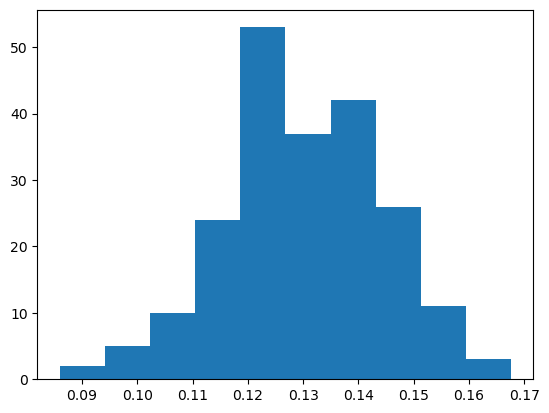

0.12996637831691285
0.1058655858039856 0.15253765285015103


In [9]:
train_dataset2 = CustomDataset(csv_file=os.path.join(path,"train.csv"), transform=transform)
train_loader2 = DataLoader(train_dataset2, shuffle=False)

correct = 0
total = 0
train_embeddings = []
test_pred = []
loss_list = []
with torch.no_grad():
    for data in train_loader2:
        images = data
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images.view(images.size(0), -1).to(device)).to(device).item()
        loss_list.append(loss)
        train_embeddings.append(outputs.cpu().numpy().squeeze())
# print(loss_list)
plt.hist(loss_list)
plt.show()
print(np.mean(loss_list))
m1 = np.percentile(np.array(loss_list), 5, axis=0)
m2 = np.percentile(np.array(loss_list), 95, axis=0)
print(m1,m2)
            

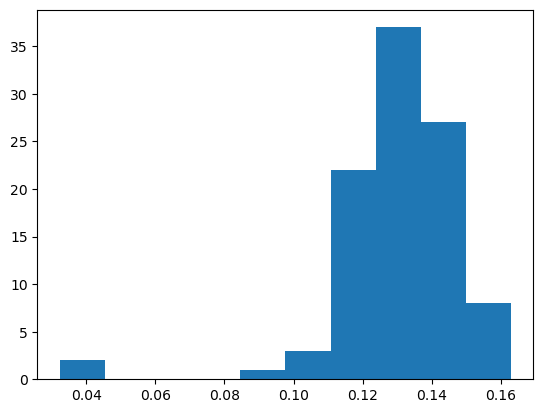

In [10]:
test_dataset = CustomDataset(csv_file=os.path.join(path,"test.csv"), transform=transform)
test_loader = DataLoader(test_dataset, shuffle=False)

correct = 0
total = 0
test_pred = []
test_embeddings = []
loss_list = []
with torch.no_grad():
    for data in test_loader:
        images = data
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images.view(images.size(0), -1).to(device)).to(device).item()
        loss_list.append(loss)
        test_embeddings.append(outputs.cpu().numpy().squeeze())
        if loss<=m1 or loss>=m2:
            test_pred.append(0.)
        else:
            test_pred.append(1.)
plt.hist(loss_list)
plt.show()            

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Isolation Forest 모델 학습
clf = IsolationForest(random_state=1016)
clf.fit(train_embeddings)

IsolationForest(random_state=1016)

In [13]:
test_pred = clf.predict(test_embeddings)
# Isolation Forest의 예측 결과(이상 = -1, 정상 = 1)를 이상 = 1, 정상 = 0으로 변환
test_pred = np.where(test_pred == -1, 1, 0)

Text(50.722222222222214, 0.5, 'True Label')

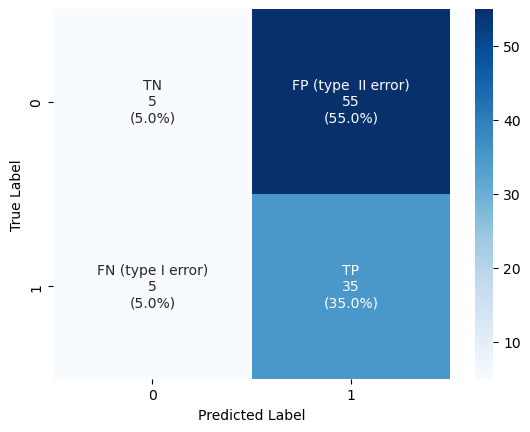

In [10]:
answer = [0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,1,1,1,0,1,0,0,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,1,1,1,1,1,0,0,1,1]
cf_matrix = confusion_matrix(answer, test_pred)
group_names = ["TN", "FP (type  II error)", "FN (type I error)", "TP"]
group_counts = [value for value in cf_matrix.flatten()]
group_percentages = [f"{value:.1%}" for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n({v3})" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
labels
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [14]:
submit = pd.read_csv(os.path.join(path,"sample_submission.csv"))
submit['label'] = test_pred
submit.head()

,id,label
0,TEST_000,0
1,TEST_001,0
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0


In [15]:
submit.to_csv(os.path.join(save_path,"submit48.csv"), index=False)